In [3]:
import warnings
from tqdm import tqdm

warnings.simplefilter('ignore')
import time
from collections import OrderedDict

import re

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


import nltk
nltk.download('punkt')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import string
import time

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [14]:
def preprocess_string(s):
    s = re.sub(r'[^\w\s]', '', s) # remove punctuation
    s = re.sub(r'\s+', '', s) # remove whitespace
    s = re.sub(r'\d', '', s) # remove numbers
    return s

In [15]:
song= """We are no strangers to love
You know the rules and so do I
A full commitments what Im thinking of
You wouldnt get this from any other guy
I just wanna tell you how Im feeling
Gotta make you understand
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Weve known each other for so long
Your hearts been aching but youre too shy to say it
Inside we both know whats been going on
We know the game and were gonna play it
And if you ask me how Im feeling
Dont tell me youre too blind to see
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Weve known each other for so long
Your hearts been aching but youre too shy to say it
Inside we both know whats been going on
We know the game and were gonna play it
I just wanna tell you how Im feeling
Gotta make you understand
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you"""

In [18]:
from nltk.tokenize import word_tokenize
def preprocess(words):
    tokens = word_tokenize(words)
    tokens = [preprocess_string(w) for w in tokens]
    return [w.lower() for w in tokens if len(w)!=0 or not(w in string.punctuation)]

tokens = preprocess(song)
tokens[0:10]

['we', 'are', 'no', 'strangers', 'to', 'love', 'you', 'know', 'the', 'rules']

In [19]:
# Create a frequency distribution of words
fdist = nltk.FreqDist(tokens)
fdist

FreqDist({'na': 40, 'gon': 38, 'you': 37, 'never': 36, 'and': 16, 'tell': 9, 'make': 8, 'say': 8, 'a': 7, 'give': 6, ...})

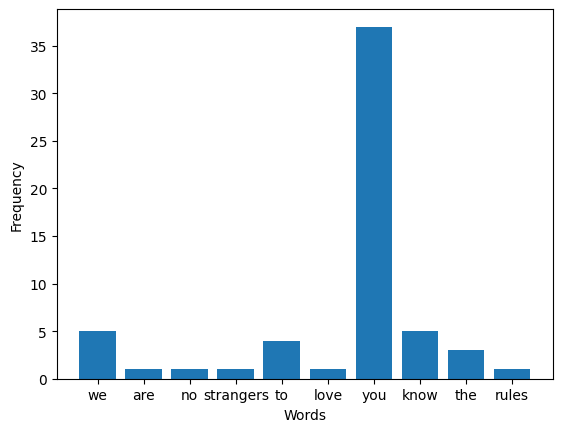

In [20]:
plt.bar(list(fdist.keys())[0:10],list(fdist.values())[0:10])
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

In [21]:
#total count of each word 
C=sum(fdist.values())
C

385

In [22]:
fdist['strangers']/C

0.0025974025974025974

In [23]:
vocabulary=set(tokens)

In [24]:
bigrams = nltk.bigrams(tokens)
bigrams

<generator object bigrams at 0x30de90740>

In [25]:
my_bigrams=list(nltk.bigrams(tokens))

In [26]:
my_bigrams[0:10]

[('we', 'are'),
 ('are', 'no'),
 ('no', 'strangers'),
 ('strangers', 'to'),
 ('to', 'love'),
 ('love', 'you'),
 ('you', 'know'),
 ('know', 'the'),
 ('the', 'rules'),
 ('rules', 'and')]

In [27]:
freq_bigrams  = nltk.FreqDist(nltk.bigrams(tokens))
freq_bigrams

FreqDist({('gon', 'na'): 38, ('never', 'gon'): 36, ('you', 'never'): 9, ('na', 'tell'): 8, ('make', 'you'): 8, ('na', 'give'): 6, ('give', 'you'): 6, ('you', 'up'): 6, ('up', 'never'): 6, ('na', 'let'): 6, ...})

In [28]:
freq_bigrams[('we', 'are')]

1

In [29]:
for my_bigram in  my_bigrams[0:10]:
    print(my_bigram)
    print(freq_bigrams[my_bigram])

('we', 'are')
1
('are', 'no')
1
('no', 'strangers')
1
('strangers', 'to')
1
('to', 'love')
1
('love', 'you')
1
('you', 'know')
1
('know', 'the')
3
('the', 'rules')
1
('rules', 'and')
1


In [30]:
word="strangers"
vocab_probabilities={}
for next_word in vocabulary:
    vocab_probabilities[next_word]=freq_bigrams[(word,next_word)]/fdist[word]

vocab_probabilities=sorted(vocab_probabilities.items(), key=lambda x:x[1],reverse=True)

In [31]:
vocab_probabilities[0:4]

[('to', 1.0), ('wouldnt', 0.0), ('hearts', 0.0), ('aching', 0.0)]

In [32]:
def make_predictions(my_words, freq_grams, normlize=1, vocabulary=vocabulary):
    """
    Generate predictions for the conditional probability of the next word given a sequence.

    Args:
        my_words (list): A list of words in the input sequence.
        freq_grams (dict): A dictionary containing frequency of n-grams.
        normlize (int): A normalization factor for calculating probabilities.
        vocabulary (list): A list of words in the vocabulary.

    Returns:
        list: A list of predicted words along with their probabilities, sorted in descending order.
    """

    vocab_probabilities = {}  # Initialize a dictionary to store predicted word probabilities

    context_size = len(list(freq_grams.keys())[0])  # Determine the context size from n-grams keys

    # Preprocess input words and take only the relevant context words
    my_tokens = preprocess(my_words)[0:context_size - 1]

    # Calculate probabilities for each word in the vocabulary given the context
    for next_word in vocabulary:
        temp = my_tokens.copy()
        temp.append(next_word)  # Add the next word to the context

        # Calculate the conditional probability using the frequency information
        if normlize!=0:
            vocab_probabilities[next_word] = freq_grams[tuple(temp)] / normlize
        else:
            vocab_probabilities[next_word] = freq_grams[tuple(temp)] 
    # Sort the predicted words based on their probabilities in descending order
    vocab_probabilities = sorted(vocab_probabilities.items(), key=lambda x: x[1], reverse=True)

    return vocab_probabilities  # Return the sorted list of predicted words and their probabilities

In [33]:
my_words="are"

vocab_probabilities=make_predictions(my_words,freq_bigrams,normlize=fdist['i'])

In [34]:
vocab_probabilities[0:10]

[('no', 0.3333333333333333),
 ('wouldnt', 0.0),
 ('hearts', 0.0),
 ('aching', 0.0),
 ('blind', 0.0),
 ('thinking', 0.0),
 ('the', 0.0),
 ('run', 0.0),
 ('lie', 0.0),
 ('we', 0.0)]

In [35]:
vocab_probabilities[0][0]

'no'

In [36]:
my_song=""
for w in tokens[0:100]:
  my_word=make_predictions(w,freq_bigrams)[0][0]
  my_song+=" "+my_word

In [38]:
my_song

' know no strangers to say you never the game and hurt long i just lie commitments what im feeling of you never get this from any other for i just wan na tell a never im feeling got ta make you never never gon na tell you never never gon na tell you never never gon na tell around and hurt you never gon na tell you never never gon na tell goodbye never gon na tell a lie and hurt you never known each other for so long your hearts been aching but youre too shy to say goodbye'

In [39]:
my_song="i"

for i in range(100):
    my_word=make_predictions(my_word,freq_bigrams)[0][0]
    my_song+=" "+my_word

In [40]:
my_song

'i never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never'

In [41]:
freq_trigrams  = nltk.FreqDist(nltk.trigrams(tokens))
freq_trigrams

FreqDist({('never', 'gon', 'na'): 36, ('you', 'never', 'gon'): 9, ('gon', 'na', 'give'): 6, ('na', 'give', 'you'): 6, ('give', 'you', 'up'): 6, ('you', 'up', 'never'): 6, ('up', 'never', 'gon'): 6, ('gon', 'na', 'let'): 6, ('na', 'let', 'you'): 6, ('let', 'you', 'down'): 6, ...})

In [42]:
make_predictions("so do",freq_trigrams,normlize=freq_bigrams[('do','i')] )[0:10]

[('i', 1.0),
 ('wouldnt', 0.0),
 ('hearts', 0.0),
 ('aching', 0.0),
 ('blind', 0.0),
 ('thinking', 0.0),
 ('the', 0.0),
 ('no', 0.0),
 ('run', 0.0),
 ('lie', 0.0)]

In [43]:
my_song=""

w1=tokens[0]
for w2 in tokens[0:100]:
    gram=w1+' '+w2
    my_word=make_predictions(gram,freq_trigrams )[0][0]
    my_song+=" "+my_word
    w1=w2

In [44]:
my_song

' wouldnt no strangers to love you know the game and so do i a full commitments what im thinking of you wouldnt get this from any other guy i just wan na tell a how im feeling got ta make you cry never gon na run you up never gon na run you down never gon na run around and desert you never gon na run you cry never gon na run goodbye never gon na run a lie and hurt you never known each other for so long your hearts been aching but youre too shy to say it'

In [45]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [46]:
tokenizer = get_tokenizer("basic_english")
tokens=tokenizer(song)

In [47]:
# Create a vocabulary from text tokens

# tokenize the 'song' text using the provided tokenizer.
# The map function applies the tokenizer to each word in the 'song' after splitting it.
# The result is a list of tokens representing the words in the 'song'.
tokenized_song = map(tokenizer, song.split())

# Step 2: Vocabulary Building
# The build_vocab_from_iterator function constructs a vocabulary from the tokenized text.
# In this case, add a special token "<unk>" (unknown token) to handle out-of-vocabulary words.
vocab = build_vocab_from_iterator(tokenized_song, specials=["<unk>"])

# Step 3: Set Default Index
# Set the default index for the vocabulary to the index corresponding to the "<unk>" token.
# This ensures that any unknown tokens in the future will be mapped to this index.
vocab.set_default_index(vocab["<unk>"])

In [48]:
vocab(tokens[0:10])

[21, 58, 70, 74, 25, 69, 2, 20, 31, 72]

In [49]:
text_pipeline = lambda x: vocab(tokenizer(x))
text_pipeline(song)[0:10]

[21, 58, 70, 74, 25, 69, 2, 20, 31, 72]

In [50]:
index_to_token = vocab.get_itos()
index_to_token[0]

'<unk>'

In [51]:
embedding_dim=20
vocab_size=len(vocab)
embeddings = nn.Embedding(vocab_size, embedding_dim)

In [52]:
for n in range(2): 
    embedding=embeddings(torch.tensor(n))
    print("word",index_to_token[n])
    print("index",n)
    print( "embedding", embedding)
    print("embedding shape", embedding.shape)

word <unk>
index 0
embedding tensor([ 0.7988,  0.1261, -2.3229,  0.6989,  0.5282, -0.7043, -0.4947, -0.9067,
         0.0806,  1.5655,  0.7482, -1.5649,  0.7480,  0.1054,  1.1209,  0.6511,
        -1.0521,  2.4766,  0.5570, -0.5978], grad_fn=<EmbeddingBackward0>)
embedding shape torch.Size([20])
word gonna
index 1
embedding tensor([-1.2215, -2.4200,  1.1854,  1.6823, -1.4244,  0.6136, -0.4925, -0.3780,
        -0.8795, -0.5117,  0.8702,  1.4016,  1.8434,  1.2898,  1.9072,  0.2342,
         0.8594,  0.5661,  0.7692,  0.0945], grad_fn=<EmbeddingBackward0>)
embedding shape torch.Size([20])


In [53]:
CONTEXT_SIZE=2

ngrams = [
    (
        [tokens[i - j - 1] for j in range(CONTEXT_SIZE)],
        tokens[i]
    )
    for i in range(CONTEXT_SIZE, len(tokens))
]

In [54]:
context, target=ngrams[0]
print("context",context,"target",target)
print("context index",vocab(context),"target index",vocab([target]))

context ['are', 'we'] target no
context index [58, 21] target index [70]


In [55]:
linear = nn.Linear(embedding_dim*CONTEXT_SIZE,128)

In [56]:
my_embeddings=embeddings(torch.tensor(vocab(context)))
my_embeddings.shape

torch.Size([2, 20])

In [57]:
my_embeddings=my_embeddings.reshape(1,-1)
my_embeddings.shape

torch.Size([1, 40])

In [58]:
linear(my_embeddings)

tensor([[-0.4115,  0.5719,  0.3606, -0.0588,  1.1298,  0.1657,  0.3785, -0.2547,
         -0.1453, -0.3204,  0.0629,  0.5239,  0.3783,  0.4840, -1.0009, -0.2500,
         -0.1284, -0.7330,  0.1765, -0.4735, -0.3401, -0.6754,  0.4267,  0.2663,
         -0.1756,  0.0570, -0.4305, -0.9086,  0.1916,  0.3016,  0.5835,  0.1771,
          0.2405,  0.5908, -0.2783, -0.7992, -0.2684,  0.0381, -0.0465, -0.2735,
          0.0854,  0.1703, -0.0980,  0.0166,  0.2809, -0.8557, -0.6712, -0.1102,
          0.2541, -0.1072, -0.5335,  0.9070,  0.5251,  0.0514, -0.9803,  0.0823,
         -0.4192,  0.7088, -0.1348,  0.3545,  0.1348, -0.7404,  0.9039, -0.9821,
         -0.4955, -0.1915, -0.5062,  0.2691,  0.4758,  0.4556,  0.0980,  0.3324,
          0.0261, -0.0913, -0.2255, -0.3136,  0.6491, -0.1869,  0.9159,  0.2848,
         -0.0465,  0.5916, -0.1876,  0.7861,  0.4683,  0.0271, -0.7015,  0.2744,
          0.0140,  0.4531,  0.4967, -0.4473, -0.5093, -1.2134, -0.3091, -0.6421,
          0.1677,  0.2087, -

In [59]:
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CONTEXT_SIZE=3
BATCH_SIZE=10
EMBEDDING_DIM = 10

def collate_batch(batch):
    batch_size=len(batch)
    context, target=[],[]
    for i in range(CONTEXT_SIZE,batch_size):
        target.append(vocab([batch[i]]))
        context.append(vocab([batch[i-j-1] for j in range(CONTEXT_SIZE)]))

    return   torch.tensor(context).to(device),  torch.tensor(target).to(device).reshape(-1)

In [60]:
Padding=BATCH_SIZE-len(tokens)%BATCH_SIZE
tokens_pad=tokens+tokens[0:Padding]


In [61]:
dataloader = DataLoader(
     tokens_pad, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch
)

In [62]:
class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.context_size=context_size
        self.embedding_dim=embedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs)
        embeds=torch.reshape( embeds, (-1,self.context_size * self.embedding_dim))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)

        return out

In [63]:
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE).to(device)

In [64]:
context, target=next(iter(dataloader))
out=model(context)

In [65]:
out.shape

torch.Size([7, 79])

In [66]:
predicted_index =torch.argmax(out,1)
predicted_index

tensor([11, 18, 40,  1,  1,  1, 74])

In [67]:
[index_to_token[i.item()] for i in  predicted_index]

['desert', 'run', 'going', 'gonna', 'gonna', 'gonna', 'strangers']

In [68]:
def write_song(model,number_of_words=100):
    my_song=""
    for i in range(number_of_words):
        with torch.no_grad():
            context=torch.tensor(vocab([tokens[i-j-1] for j in range(CONTEXT_SIZE)])).to(device)
            word_inx=torch.argmax(model(context))
            my_song+=" "+index_to_token[word_inx.detach().item()]

    return my_song

In [69]:
write_song(model)

' are gonna desert desert run going gonna gonna gonna strangers gonna gonna gonna desert gonna gonna never gonna commitments gonna gonna gonna feeling gonna gonna gonna gonna commitments hearts hearts gonna gonna lie gonna gonna gonna gonna gonna hearts but desert gonna hearts gonna gonna gonna gonna hearts gonna desert <unk> gonna hearts gonna desert gonna how to but commitments im desert gonna wouldnt hearts but gonna gonna run run run gonna feeling gonna feeling are gonna gonna desert <unk> hearts gonna desert hearts gonna gonna gonna gonna gonna gonna i known feeling gonna hearts gonna gonna feeling feeling gonna'

In [70]:
criterion = torch.nn.CrossEntropyLoss()

In [71]:
def train(dataloader, model, number_of_epochs=100, show=10):
    """
    Args:
        dataloader (DataLoader): DataLoader containing training data.
        model (nn.Module): Neural network model to be trained.
        number_of_epochs (int, optional): Number of epochs for training. Default is 100.
        show (int, optional): Interval for displaying progress. Default is 10.

    Returns:
        list: List containing loss values for each epoch.
    """

    MY_LOSS = []  # List to store loss values for each epoch

    # Iterate over the specified number of epochs
    for epoch in tqdm(range(number_of_epochs)):
        total_loss = 0  # Initialize total loss for the current epoch
        my_song = ""    # Initialize a string to store the generated song

        # Iterate over batches in the dataloader
        for context, target in dataloader:
            model.zero_grad()          # Zero the gradients to avoid accumulation
            predicted = model(context)  # Forward pass through the model to get predictions
            loss = criterion(predicted, target.reshape(-1))  # Calculate the loss
            total_loss += loss.item()   # Accumulate the loss

            loss.backward()    # Backpropagation to compute gradients
            optimizer.step()   # Update model parameters using the optimizer

        # Display progress and generate song at specified intervals
        if epoch % show == 0:
            my_song += write_song(model)  # Generate song using the model

            print("Generated Song:")
            print("\n")
            print(my_song)

        MY_LOSS.append(total_loss/len(dataloader))  # Append the total loss for the epoch to MY_LOSS list

    return MY_LOSS  # Return the list of  mean loss values for each epoch

In [72]:
my_loss_list=[]

In [73]:
# Define the context size for the n-gram model
CONTEXT_SIZE = 2

# Create an instance of the NGramLanguageModeler class with specified parameters
model_2 = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE).to(device)

# Define the optimizer for training the model, using stochastic gradient descent (SGD)
optimizer = optim.SGD(model_2.parameters(), lr=0.01)

# Set up a learning rate scheduler using StepLR to adjust the learning rate during training
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1.0, gamma=0.1)

In [74]:
my_loss=train(dataloader,model_2)

 26%|██▌       | 26/100 [00:00<00:00, 122.11it/s]

Generated Song:


 make down down both ask full make too up gonna youre full ask gonna it it gonna down down gonna from make too never around up it let down gonna it lie too around tell never let the gonna gonna it gonna gonna down gonna both any gonna down gonna tell whats gonna down gonna make full down gonna gonna down gonna it never gonna down let the gonna down around ask gonna full make make around each make lie let any gonna hearts aching around make lie both full too around feeling full full ask around make gonna full
Generated Song:


 never never never you never you you never never you gonna never you you never gonna you you you you you you never never never never never you you you never gonna never never never never never never gonna gonna never gonna gonna tell you never never gonna tell you never never gonna tell you and you you never gonna tell you never never gonna tell you never gonna tell you never gonna you you never never you you you you you gonna you you never you y

 61%|██████    | 61/100 [00:00<00:00, 152.38it/s]

Generated Song:


 never never never and never a you never never you gonna hurt you you never gonna you you you never you you never never never never never you you you never gonna tell never never im feeling and make you never never gonna tell you up never gonna tell you down never gonna tell around and desert you never gonna tell you never never gonna tell goodbye never gonna tell a never and hurt you never and each you let you you never you been never you you too you never never you goodbye never you a never gonna tell
Generated Song:


 never never never and never a you never never you and hurt you gonna a gonna you you you never you you up never never never never you tell you never gonna tell never never im feeling and make you cry never gonna tell you up never gonna tell you down never gonna tell around and desert you never gonna tell you cry never gonna tell goodbye never gonna tell a lie and hurt you never and each other for you you never you been never you you too you never nev

100%|██████████| 100/100 [00:00<00:00, 152.94it/s]

Generated Song:


 never never too strangers to love you cry the game and hurt you i a gonna you im you never i you up never never know any other play you never gonna tell you how im feeling gotta make you cry never gonna tell you up never gonna tell you down never gonna tell around and desert you never gonna tell you cry never gonna tell goodbye never gonna tell a lie and hurt you never known each other for you you never hearts been aching but youre too shy to love it inside we you know whats been going
Generated Song:


 never never no strangers to love you cry the game and hurt you i a full you im you thinking i you up never never know any other play you never gonna tell you how im feeling gotta make you cry never gonna tell you up never gonna tell you down never gonna tell around and desert you never gonna tell you cry never gonna tell goodbye never gonna tell a lie and hurt you never known each other for you you never hearts been aching but youre too shy to love it inside we both 

In [75]:
save_path = '2gram.pth'
torch.save(model_2.state_dict(), save_path)
my_loss_list.append(my_loss)

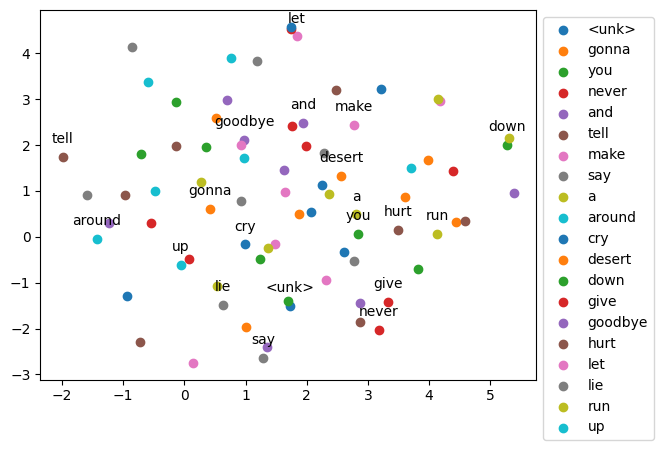

In [76]:
X = model_2.embeddings.weight.cpu().detach().numpy()
tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X)

labels = []

for j in range(len(X_2d)):
    if j < 20:
        plt.scatter(X_2d[j, 0], X_2d[j, 1], label=index_to_token[j])
        labels.append(index_to_token[j])
        # Add words as annotations
        plt.annotate(index_to_token[j],
                     (X_2d[j, 0], X_2d[j, 1]),
                     textcoords="offset points",
                     xytext=(0, 10),
                     ha='center')
    else:
        plt.scatter(X_2d[j, 0], X_2d[j, 1])

plt.legend(labels, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [77]:
CONTEXT_SIZE=4
model_4 = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE).to(device)
optimizer = optim.SGD(model_4.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
my_loss=train(dataloader,model_4 )

save_path = '4gram.pth'
torch.save(model_4.state_dict(), save_path)

my_loss_list.append(my_loss)

 28%|██▊       | 28/100 [00:00<00:00, 142.65it/s]

Generated Song:


 gotta you up love for gonna down gotta you you know blind love blind you to gonna you thinking say you desert gotta gonna gonna gonna gonna long you you you see gonna rules make you desert no to know to gonna down tell you down you gonna what you you you gonna tell you are to you to gonna make you what you down long you down you you make you you thinking you gotta you desert tell say you down down you down what make desert you full you long you desert you you make gonna you what
Generated Song:


 never never you you gonna you never never gonna you you you you gonna you never gonna you you never you and you never gonna gonna gonna never gonna gonna you never never gonna gonna never never you you you never never gonna tell you never never gonna let you never never gonna you you and desert you never gonna make you never never gonna tell you never gonna tell you never never you you never gonna gonna you never you you never never never never gonna you you never gonna you

 65%|██████▌   | 65/100 [00:00<00:00, 167.31it/s]

Generated Song:


 never known feeling you to love you never gonna make and were you gonna you full gonna you you thinking you to cry never this gonna im other tell i run never never gonna how im feeling gotta to you you never gonna say you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt you never known each other for a you never never been aching but youre too shy to you gonna to you both know whats been going
Generated Song:


 never known each you to love you know gonna make and were you gonna a full commitments you you thinking you to cry never this gonna any other tell i run never never gonna how im feeling gotta make you weve never gonna say you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt you never known each other for a you never never been aching but youre too shy to you gonna te

100%|██████████| 100/100 [00:00<00:00, 163.59it/s]

Generated Song:


 never known no strangers to love you know the rules and were you gonna a full commitments what im thinking you tell cry never this from any other guy i run never never a how im feeling gotta make you weve never gonna run you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt you never known each other for so you never never been aching but youre too shy to see gonna tell we both know whats been going
Generated Song:


 never known no strangers to love you know the rules and were you gonna a full commitments what im thinking you tell cry never this from any other guy i run never never a how im feeling gotta make you weve known gonna run you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt you never known each other for so you never never been aching but youre too shy to see gon

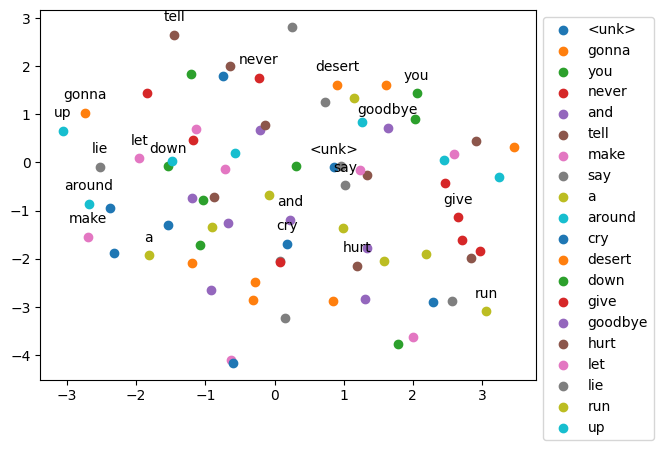

In [78]:
X = model_4.embeddings.weight.cpu().detach().numpy()
tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X)

labels = []

for j in range(len(X_2d)):
    if j < 20:
        plt.scatter(X_2d[j, 0], X_2d[j, 1], label=index_to_token[j])
        labels.append(index_to_token[j])
        # Add words as annotations
        plt.annotate(index_to_token[j],
                     (X_2d[j, 0], X_2d[j, 1]),
                     textcoords="offset points",
                     xytext=(0, 10),
                     ha='center')
    else:
        plt.scatter(X_2d[j, 0], X_2d[j, 1])

plt.legend(labels, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [79]:
CONTEXT_SIZE=8
model_8 = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE).to(device)
optimizer = optim.SGD(model_8.parameters(), lr=0.01)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
my_loss=train(dataloader,model_8)

save_path = '8gram.pth'
torch.save(model_8.state_dict(), save_path)

my_loss_list.append(my_loss)

 31%|███       | 31/100 [00:00<00:00, 157.79it/s]

Generated Song:


 you full both gonna gonna gonna you gonna gonna both you down gonna gonna gonna you both how how thinking gonna down down gonna gonna other too gonna gonna gonna known you shy gonna <unk> both both both gonna full gonna gonna gonna gonna both gonna but gonna you you down gonna gonna you you full down guy aching gonna too other never gonna gonna gonna you gonna you lie gonna lie but down you you both you gonna gonna gonna down gonna gonna gonna never we down gonna make never gonna <unk> you i do lie goodbye lie no
Generated Song:


 never tell never you make love you never the you you you never gonna never you make never make never never never you gonna make you make gonna gonna i you tell you gonna never never never you make you never gonna gonna tell you never never gonna let you down never tell you around and gonna tell never gonna make you never never gonna let you down gonna tell a lie you you you never never never you for make you you gonna make you never make t

 72%|███████▏  | 72/100 [00:00<00:00, 185.73it/s]

Generated Song:


 never too never other make love you never the rules you you love you tell you tell never im thinking never never never make make you make love guy i you tell shy play never never never you make you never gonna gonna tell you down never gonna let you down never tell run around and gonna tell never gonna make you up never gonna say you down gonna tell a lie never hurt you never down never other for so you you lie i play you never too shy to you you you i you im you been going
Generated Song:


 never too never other make love you never the rules you you love you play you tell never im thinking never never never make make you make love guy i you tell shy play never never never you make you never gonna gonna tell you down never gonna let you down never tell run around and gonna tell never gonna make you up never gonna say you down gonna tell a lie never hurt you never down never other for so you you lie i play you never too shy to you love you i you im you been going
Gen

100%|██████████| 100/100 [00:00<00:00, 179.31it/s]

Generated Song:


 never too never other make love you never the rules you you love you play you tell never im thinking never never never make make you make love guy i you tell shy play never never never you make you never gonna gonna tell you down never gonna let you down never tell run around and gonna tell never gonna make you up never gonna say you down gonna tell a lie never hurt you never never never other for so you you lie i play you never too shy to you love you i you im you been going


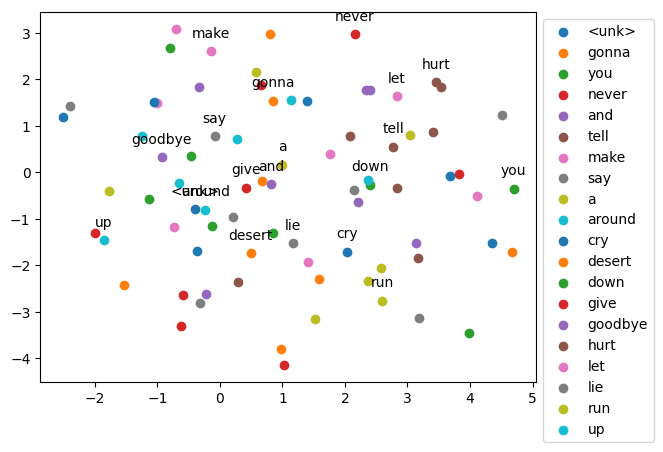

In [80]:
X = model_8.embeddings.weight.cpu().detach().numpy()
tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X)

labels = []

for j in range(len(X_2d)):
    if j < 20:
        plt.scatter(X_2d[j, 0], X_2d[j, 1], label=index_to_token[j])
        labels.append(index_to_token[j])
        # Add words as annotations
        plt.annotate(index_to_token[j],
                     (X_2d[j, 0], X_2d[j, 1]),
                     textcoords="offset points",
                     xytext=(0, 10),
                     ha='center')
    else:
        plt.scatter(X_2d[j, 0], X_2d[j, 1])

plt.legend(labels, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

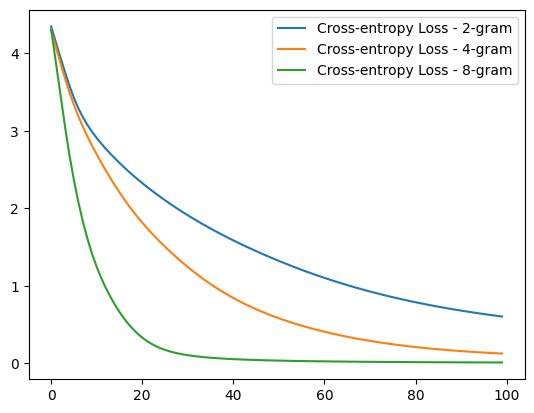

In [81]:
for (my_loss, model_name)in zip(my_loss_list,["2-gram","4-gram","8-gram"]):
    plt.plot(my_loss,label="Cross-entropy Loss - {}".format(model_name))
    plt.legend()

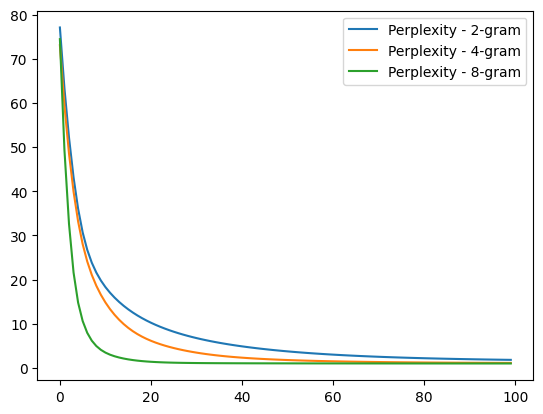

In [82]:
for (my_loss, model_name)in zip(my_loss_list,["2-gram","4-gram","8-gram"]):
    # Calculate perplexity using the loss
    perplexity = np.exp(my_loss)
    plt.plot(perplexity,label="Perplexity - {}".format(model_name))
    plt.legend()

In [83]:
nursery_rhymes = """
Little Miss Muffet
Sat on a tuffet,
Eating her curds and whey;
Along came a spider
Who sat down beside her
And frightened Miss Muffet away.

Twinkle, twinkle, little star,
How I wonder what you are!
Up above the world so high,
Like a diamond in the sky.

Baa, baa, black sheep,
Have you any wool?
Yes sir, yes sir,
Three bags full.

Jack and Jill went up the hill
To fetch a pail of water.
Jack fell down and broke his crown,
And Jill came tumbling after.

Hickory dickory dock,
The mouse ran up the clock.
The clock struck one,
The mouse ran down,
Hickory dickory dock.

Humpty Dumpty sat on a wall,
Humpty Dumpty had a great fall.
All the king's horses and all the king's men
Couldn't put Humpty together again.

Mary had a little lamb,
Its fleece was white as snow;
And everywhere that Mary went,
The lamb was sure to go.

Old MacDonald had a farm,
E-I-E-I-O,
And on his farm he had a cow,
E-I-E-I-O.

Itsy Bitsy Spider climbed up the waterspout.
Down came the rain and washed the spider out.
Out came the sun and dried up all the rain,
And the Itsy Bitsy Spider climbed up the spout again.

The wheels on the bus go round and round,
Round and round,
Round and round.
The wheels on the bus go round and round,
All through the town.

"""

In [84]:
N=2
tokens = preprocess(nursery_rhymes)  # Use the preprocess function provided in the code.
ngrams = list(nltk.ngrams(tokens, N))  # Where N is the size of the n-gram (2, 4, 8, etc.).

In [85]:
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
loss_history = train(dataloader, model)

 36%|███▌      | 36/100 [00:00<00:00, 179.71it/s]

Generated Song:


 you you game you you you you game game you you to game you game you you you you you you you to game you game you you you you you you you you game game how a game both it you up up you game you you you youre you you you you you you you game game you you you you you game you game you long you you on up you on up you you each just you you game game to a you game you you you you you game you to you you a game
Generated Song:


 you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you gonna you you make never you you you you you you you you you you you you you you you you you you you you you you you you you you you you gonna you you gonna you you you you you you you you you you never you you you you you you you you you you you you you you you you you
Generated Song:


 you you never you you you you you you you you gonna you you you you you you you you you you you you you you you you you you

 75%|███████▌  | 75/100 [00:00<00:00, 186.62it/s]

Generated Song:


 you you never you you you you never you you you gonna you you you you you you you you you you gonna you you you you you you you you you you you never gonna never you make never you make i you never you make you you you never you you you make never you im never you you you you you you gonna you you gonna you you a you you never you you you never you you you never never you you never never you you you you you you you never you you never make
Generated Song:


 you you never you you you you never you you you gonna you you you you you you you you you you gonna you you you you you you you you you you you never gonna never you make never you make i you never you make you you you never you you you make never you im never you you you you you you gonna you you gonna you you a you you never you you you never gonna you you never never you you never never you you you you you you you never you you never make
Generated Song:


 you you never you you you you never you you you gonna

100%|██████████| 100/100 [00:00<00:00, 184.03it/s]

Generated Song:


 you you never you you you you never you you you gonna you you you you thinking you you you you you gonna you you gonna you you you you you you you you never gonna never you make never you make i you never you make you you you never you you you make never you im never you you you you you you gonna you you gonna you you a im you never you you you never gonna you you never never you you never never you you you you you you you never you you never make
Generated Song:


 you you never you you you you never you you you gonna you you you you thinking you you you you you gonna you you gonna you you you you you you you you never gonna never you make never you make i you never you make you you you never you you you make never you im never you you you you thinking you gonna you you gonna you you a im you never you you you never gonna you you never never you you never never you you you you you you you never you you never make


In [86]:
generated_rhyme = write_song(model)
print(generated_rhyme)

 you you never you you you you never you you you gonna you you you you thinking you you you you you gonna you you gonna you you you you you you you you never gonna never you make never you make i you never you make you you you never you you you make never you im never you you you you thinking you gonna you you gonna you you a im you never you you you never gonna you you never never you you never never you you you you you you you never you you never make
